# Nozzle Design Version 1

In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

This notebook calculates the 1D isentropic flow through a supersonic gas jet nozzle with a given area profile.

The mach number is related to the area of the nozzle by
$$\frac{A}{A^*} = \frac{1}{M}\left(\frac{2+(k-1)M^2}{1+k}\right)^{(k+1)/[2(k-1)]},$$
where $A^*$ is the throat area of the converging diverging nozzle. As an aside, in a sonic nozzle the above equation still works but the value of $A^*$ does not correspond to a physical area in the nozzle. Instead, it can be interpretted as the area the throat would have to be reduced to in order to form a supersonic nozzle. 

Once the mach number through the nozzle is determined, the pressure, temperature, and density follow straightforwardly:
$$\frac{p}{p_0} = \left(\frac{2}{2+(k-1)M^2}\right)^{k/(k-1)},$$
$$\frac{T}{T_0} = \frac{2}{2+(k-1)M^2},$$
$$\frac{\rho}{\rho_0} = \left(\frac{2}{2+(k-1)M^2}\right)^{1/(k-1)}$$

For the 1D isentropic flow approximation to be correct, the nozzle has to have smooth walls and thus the theory does not apply in the upstream reservoir or after the exit of the nozzle. The consequence of this is that the pressure at the entrance of the nozzle can be lower than the pressure of the reservoir and the pressure at the exit of the nozzle can be higher than the background pressure.

Typically, the radius that includes 95% of the mass flow is used to measure the plume expansion on cylindrical gas jets. From Schmid and Veisz (2012) the expansion of this radius is typically linear leading to a $1/z^2$ reduction in gas density as the plume expands. Assuming a linear expansion in one direction for an elongated gas jet, the density should reduce as $1/z$ above the gas jet. They measured expansion cones half angles on the order of 30deg so the density should increase above the nozzle as
$$\rho = \rho_e\frac{1}{1+(2z\sin\theta)/w_e} = \rho_e\frac{1}{1+z/w},$$
where $w$ is the width of the nozzle exit and $z$ is the distance above the nozzle exit.

Bessel beam ionization optics require a beam stay clear 2cm in diameter meaning the plasma has to be formed at least 1cm above the exit of the nozzle. For repitition rate reasons, it is advantageous to reduce the gas flow rate through the nozzle and thus work as close to the nozzle exit as possible. The plasma is thus formed $z_p=1\,\mathrm{cm}$ above the exit of the nozzle. Assuming a hydrogen plasma, the plasma density is twice the gas density $n_{e0}=2\rho$. Putting this together the gas density at the nozzle exit is given by
$$\rho_e = \frac{1}{2}n_{e0}\left(1+\frac{z_p}{w_e}\right).$$

In [2]:
# Estimate the nozzle width and gas density required at the exit of the nozzle
# for a target plasma density of n_e=3.5e16cm^-3 1cm above the nozzle
# Assuming a hydrogen plasma, the plasma desnity is double the gas density
z_p = 10. #mm
n_e0 = 3.5e16 #cm^-3
L = 400. #mm
k = 1.41
T_0 = 300 #K

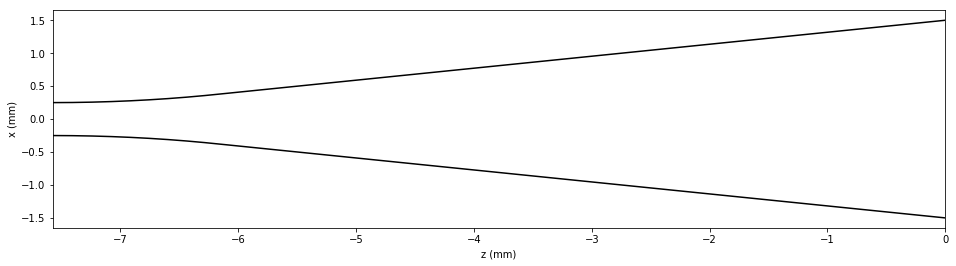

In [3]:
# The diverging part of the nozzle is a simple conical nozzle with half angle alpha
# The throat will be radiused with radius r_t and width w_t
# The area ratio is equal to the width ratio of the nozzle, w_e/w_t
alpha = np.radians(10.)*2 # deg
w_e = 3. #mm
w_t = 0.5 #mm
r_t = 4. #mm
Z_n = r_t*np.sin(alpha)+(w_e-w_t-r_t*(1-np.cos(alpha)))/np.tan(alpha)
N = 1000
z_d, dz = np.linspace(-Z_n, 0, N, retstep=True)
w_d = np.zeros(N)
# Throat curvature
edge = -Z_n+r_t*np.sin(alpha)
sel = z_d <= edge
w_d[sel] = (w_t-np.sqrt(r_t**2-(z_d[sel]+Z_n)**2)+r_t)
# Conical nozzle
sel = z_d > edge
w_d[sel] = (w_t+r_t*(1-np.cos(alpha)))+np.tan(alpha)*(z_d[sel]-z_d[sel][0]+0.5*dz)

plt.figure(figsize=(16, 4))
plt.plot(z_d, w_d/2, 'k')
plt.plot(z_d, -w_d/2, 'k')
plt.xlabel('z (mm)')
plt.ylabel('x (mm)')
plt.xlim(-Z_n, 0)
plt.show()

In [4]:
# The diverging part of the nozzle into vaccum is 
AA = lambda M: (1/M)*((2+(k-1)*M**2)/(1+k))**((k+1)/(2*k-2))
# Invert the top half of the curve above M=1
M = np.linspace(1, 8, 1000)
MofA = interp1d(AA(M), M)
M = MofA(w_d/w_t)
M_d = M
T = 2*T_0/(2+(k-1)*M**2)
rho = (2/(2+(k-1)*M**2))**(1/(k-1))
rho_e = 0.5*n_e0*(1+z_p/w_e)
rho_0 = rho_e/rho[-1]
rho = rho_0*rho
p_0 = rho_0*T_0*1.380649e-23*1e6
p = p_0*(2/(2+(k-1)*M**2))**(k/(k-1))

6 3.5


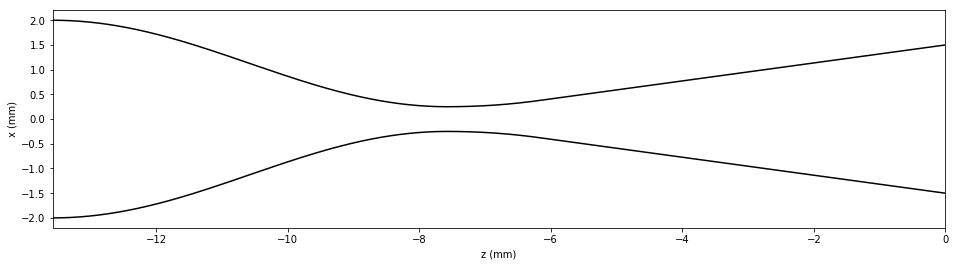

In [5]:
# The converging part of the nozzle is a cosine fuction for simplicity
N = 500
Z_d = 6 #mm
w_r = 4 #mm
z_c = np.linspace(-Z_d-Z_n, -Z_n, N, endpoint=False)
w_c = -(w_r-w_t)*np.cos(np.pi*(z_c+Z_n)/Z_d)/2+(w_r+w_t)/2
print(Z_d, (w_r-w_t))

z = np.concatenate((z_c, z_d))
w = np.concatenate((w_c, w_d))

plt.figure(figsize=(16, 4))
plt.plot(z, w/2, 'k')
plt.plot(z, -w/2, 'k')
plt.xlabel('z (mm)')
plt.ylabel('x (mm)')
plt.xlim(-Z_n-Z_d, 0)
plt.show()

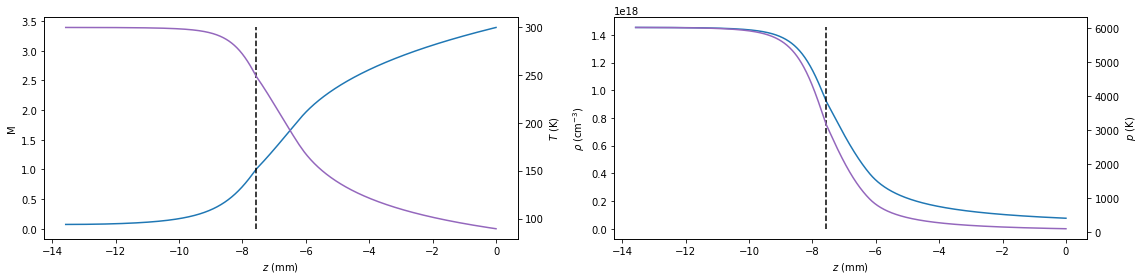

Stagnation pressure is 6034.0 Pa
Stagnation temperature is 300.0 K
Stagnation density is 1.46E+18 cm-3 or 4.88E-03 kg/m3
Outlet pressure is 93.50 Pa
Outlet temperature is 89.3 K
Stagnation pressure times nozzle width is 3.02E-02 mmbar


In [7]:
# Invert the top half of the curve above M=1
M_c = np.linspace(0.01, 1, 1000)
MofA = interp1d(AA(M_c), M_c)
M_c = MofA(w_c/w_t)
M = np.concatenate((M_c, M_d))
T = 2*T_0/(2+(k-1)*M**2)
rho = rho_0*(2/(2+(k-1)*M**2))**(1/(k-1))
p = p_0*(2/(2+(k-1)*M**2))**(k/(k-1))

plt.figure(figsize=(16, 4))
ax = plt.subplot(121)
plt.plot(z, M, 'tab:blue')
plt.plot([-Z_n, -Z_n], [0, np.max(M)], 'k--')
plt.xlabel(r'$z$ (mm)')
plt.ylabel('M')
plt.twinx()
plt.plot(z, T, 'tab:purple')
plt.ylabel(r'$T$ (K)')

plt.subplot(122)
plt.plot(z, rho, 'tab:blue')
plt.plot([-Z_n, -Z_n], [0, np.max(rho)], 'k--')
plt.xlabel(r'$z$ (mm)')
plt.ylabel(r'$\rho$ ($\mathrm{cm^{-3}}$)')
plt.twinx()
plt.plot(z, p, 'tab:purple')
plt.ylabel(r'$p$ (K)')
plt.tight_layout()
plt.show()

# p_0*w_t below 10 corresponds to significant boundary layer effects
print('Stagnation pressure is %0.1f Pa' % p_0)
print('Stagnation temperature is %0.1f K' % T_0)
print('Stagnation density is %0.2E cm-3 or %0.2E kg/m3' % (rho_0, rho_0*1e6*3.3474474e-27))
print('Outlet pressure is %0.2f Pa' % p[-1])
print('Outlet temperature is %0.1f K' % T[-1])
print('Stagnation pressure times nozzle width is %0.2E mmbar' % (p_0*w_t*1e-5))

The same nozzle is created in solidworks flow simulation as a comparison. The simulation is 2D which means it is one cell thick along the nozzle length with symmetric boundary conditions on both sdes of the cell (I assume this doesn't allow flux through the cell boundary in this direction). Using mesh refinement in a 2D simulation works poorly because the grid will be refined perpendicular to the plane. The Boundary conditions are 6034Pa at 300K total pressure on the nozzle inlet and 93.5Pa and 89.3K static pressure on the outlet. If the flow is supersonic at the outlet, which it should be for a diverging nozzle like this, solidworks ignores the set boundary conditions and the flow determines the boundary conditions.

